# **01. Preparing data needed for calc_hdx and ensemble_modeling**

In [29]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [30]:
# Matplotlib settings for plotting
plt.rc('lines', linewidth=3, markersize=4)
plt.rc('axes', labelweight='heavy', labelsize=22, titlesize=22) # Default fontsizes for printing
plt.rc('axes.spines', top=False, right=False) # Switch off top/right axes
plt.rc('legend', fontsize=16) # Default fontsizes for printing
plt.rc('xtick', labelsize=16) # Default fontsizes for printing
plt.rc('ytick', labelsize=16) # Default fontsizes for printing
plt.rc('figure', titlesize=22, titleweight='heavy') # Default fontsizes for printing

Hydrogen-deuterium exchange (HDX) is a popular biophysical tool used to study the structure and dynamics of proteins in their native or near-native environments. Typically, HDX experiments are designed to measure the exchange of protein backbone amide hydrogen atoms for deuterium atoms from a bulk deuterated solution. The rate of H-D exchange is governed by chemical factors, such as steric and inductive effects of the neighboring sidechains upon the amide functional group, and by physical factors, such as structural and dynamical protection afforded by the equilibrium motions of the protein in solution. Measuring, comparing, and rationalizing rates of exchange can therefore provide insights into the structures and dynamics of proteins under a desired set of environmental conditions. The difference in the protein from H-D exchange can be measured directly by biophysical tools such as NMR, but most recently has been popularized with mass spectrometry (HDX-MS), which avoids many limitations of protein size, concentration, and throughput, associated with other experimental techniques.

***HDXer*** is a Python package designed to 1) Predict HDX exchange rates and observed HDX measurements from biomolecular simulation data, and 2) Aid the structural interpretation of HDX experiments _via_ a Maximum-Entropy-based reweighting of simulated ensembles to best fit experimental data. These two steps are divided into two separate Python wrapper scripts: **calc_hdx.py** and **reweighting.py**. Predicted HDX deuterated fractions of a given structural ensemble are calculated using **calc_hdx.py**. Then, if desired, the structural ensemble is reweighted to match up with experimental HDX data using **reweighting.py**.

Given the vast range of software and approaches available to perform MD simulations and HDX experiments, the formats of structural ensembles and experimental HDX data may need to be pre-processed and standardized prior to using them with ***HDXer***. This notebook provides instructions on which data are needed, and how to process them.

There are four necessary data files to run ***HDXer***:
- A protein structural ensembles (e.g. molecular dynamics trajectory)
- A protein topology (e.g. a PDB file)
- Experimental HDX data (as measured HDX deuterated fractions for defined peptide segments at specific timepoints)
- A list of peptide segments with experimental HDX data

We will use published data on BPTI (Bovine Pancreatic Trpysin Inhibitor) as an example system. BPTI is one of the smallest and simplest globular proteins, which provides us two advantages:

1. HDX-MS data is collected for protein segments that are multiple residues in length. However, for BPTI, there is NMR-based HDX data available with single-residue resolution and a large coverage of the protein.

[Persson, F. and Halle, B. (2015) ‘How amide hydrogens exchange in native proteins’, Proceedings of the National Academy of Sciences, 112(33), 10383-10388. doi: 10.1073/pnas.1506079112.](https://www.pnas.org/content/112/33/10383.long)

[Kim, K.S., Fuchs, J.A., and Woodward, C.K. (1993) 'Hydrogen exchange identifies native-state motional domains important in protein folding', Biochemistry, 32(37), 9600-9608](https://pubs.acs.org/doi/abs/10.1021/bi00088a012)

[Battiste, J.L., Li, R., and Woodward, C. (2002) 'A Highly Destabilizing Mutation, G37A, of the Bovine Pancreatic Trypsin Inhibitor Retains the Average Native Conformation but Greatly Increases Local Flexibility', Biochemistry, 41(7), 2237-2245](https://pubs.acs.org/doi/full/10.1021/bi011693e?mobileUi=0)

2. In-house MD simulations

The experimental HDX data for BPTI were first reported (in the articles above by Woodward and coworkers) as observed H-D exchange rate constants for each amide, measured by NMR. However, rate constants for individual residues were variously measured at different temperatures and pD values. Persson & Halle converted the observed rate constants to equivalent temperature and pH measurements, and then reported the same data as an experimental 'protection factor' for each residue. The protection factor (PF) is a unitless constant that describes the extent to which a residue's _intrinsic_ rate of exchange is modulated by the structure and dynamics of its environment. **HDXer** requires input experimental data formatted as peptide-segment deuterated fractions at given points in time, as this is the more frequent experimental observable from HDX-MS experiments. We must therefore convert these experimental protection factors to HDX deuterated fractions at given points in time. Let's first open and look at the original data.

In [31]:
# Load experimental protection factors
expt_data = pd.read_csv(os.path.expandvars('$HDXER_PATH/protocol/BPTI/BPTI_expt_data/BPTI_expt_PFs.dat'), 
                        sep='\s+', skiprows=[0], header=None, names=['Residue', 'log10(PF)'])

We can see how the experimental data is structured by looking at the first five rows. The first column is the residue number and the second column is the corresponding protection factor.

In [32]:
expt_data.head()

,Residue,log10(PF)
0,5,3.704
1,6,3.229
2,7,3.574
3,10,2.500
4,12,1.668


Using the equation below, we can convert these experimental constants to HDX deuterated fractions.

\begin{equation*}
D_{t} = 1 - exp(\frac{-k_{int}}{P_{f}}t)
\end{equation*}

Therefore, to convert the measured protection factors we still need two values, the intrinsic rate constants of exchange ($k_{int}$), and the time points at which we which to calculate deuteration (t).

Converting from protection factors, we can choose any timepoints at all, but we will use the default time points that are used for HDX predictions by **calc_hdx.py**, ie. 0.167, 1.0, 10.0, 120.0 min.

In [33]:
times = np.array([0.167, 1.0, 10.0, 120.0]) # Create a NumPy array with time points in min                                                                                                                                                                                                                           utes

The intrinsic rate constants for each residue in BPTI depend upon the neighboring residues, and the temperature and pD of the reaction solution. In this case, we have used **calc_hdx.py** to generate a series of intrinsic exchange rate constants at pD 7.4 and 300 K. The details on how to run **calc_hdx.py** will be discussed in the next notebook.

For now, let's read the intrinsic rates file, directly as one of the **calc_hdx.py** output files, and use it to calculate deuterated fractions.

In [34]:
# Load intrinsic rates
rates = pd.read_csv(os.path.expandvars('$HDXER_PATH/protocol/BPTI/BPTI_calc_hdx/BPTI_Intrinsic_rates.dat'), 
                    sep='\s+', skiprows=[0], header=None, names=['Residue', 'k_int'])

In [35]:
rates.head()

,Residue,k_int
0,3,917.897510
1,4,481.719451
2,5,5161.716833
3,6,961.156652
4,7,606.448849


We need to only select residues for which both protection factors and intrinsic rates are available.

In [36]:
expt_data['k_int'] = rates[rates['Residue'].isin(expt_data['Residue'])]['k_int'].values

In [37]:
expt_data.head()

,Residue,log10(PF),k_int
0,5,3.704,5161.716833
1,6,3.229,961.156652
2,7,3.574,606.448849
3,10,2.500,391.556265
4,12,1.668,1874.106108


Now, we can calculate deuterated fractions for each residue and each time point using the function below:

In [38]:
def residue_fraction(pf, k, t):
    """Calculate deuterated fractions at time t using protection facotrs and intrinsic rates. 
    
    Args:
        pf: log10(PF)
        k: intrinsic rate (min^-1)
        t: time in minutes
        
    Returns:
        val: HDX deuterated fractions for each residue and time point
    
    Usage: residue_fraction(rate, t)
    """
    logf = (-k) / (10**pf) * t
    val = 1 - np.exp(logf)
    return val

In [39]:
dfracs = np.zeros((len(times), len(expt_data))) # Create a NumPy array with zeros which we will add deuterated fractions to

for i, t in enumerate(times):
    for j, (pf, k) in enumerate(zip(expt_data['log10(PF)'], expt_data['k_int'])):
        dfracs[i, j] = residue_fraction(pf, k, t)

In [40]:
# Save HDX deuterated fractions, with 2 fields for residue start/end
np.savetxt(os.path.expandvars('$HDXER_PATH/protocol/BPTI/BPTI_expt_data/BPTI_expt_dfracs.dat'), \
           np.concatenate((np.atleast_2d(expt_data['Residue'] - 1), np.atleast_2d(expt_data['Residue']), dfracs)).T, \
           fmt="%3d %3d %8.5f %8.5f %8.5f %8.5f", \
           header="ResStr, ResEnd, Deuterated fractions, Times / min: %s" \
           % ' '.join([ str(t) for t in times ]))

Now we have a new file called *BPTI_expt_dfracs.dat* that contains experimental HDX data. Let's plot this to visualize what experimental HDX data looks like.

There are two Python functions used throughout the protocol to plot HDX deuterated fractions.

The first function reads in the file such as residue segments and HDX deuterated fractions.

In [41]:
def read(file):
    """Read and create a pandas DataFrame for the given argument.
    
    Args:
        file: There are four possible options:
                'segs' - residue segments
                'expt' - experimental HDX deuterated fractions
                'pred' - predicted HDX deuterated fractions
                'reweighted' - reweighted HDX deuterated fractions
    
    Returns:
        df: A pandas DataFrame containing data for the given argument.
    """
    if file == 'segs':
        # Read and create a pandas DataFrame using a residue segments file
        df = pd.read_csv(os.path.expandvars('$HDXER_PATH/protocol/BPTI/BPTI_expt_data/BPTI_residue_segs.txt'),
                         sep='\s+', header=None, names=['ResStr', 'ResEnd'])
    elif file == 'expt':
        # Read and create a pandas DataFrame using an experimental deuterated fractions file
        df = pd.read_csv(os.path.expandvars('$HDXER_PATH/protocol/BPTI/BPTI_expt_data/BPTI_expt_dfracs.dat'), 
                         sep='\s+', skiprows=[0], header=None, usecols=[2, 3, 4, 5], names=times)
    elif file == 'pred':
        # Read and create a pandas DataFrame using a predicted deuterated fractions file
        df = pd.read_csv(os.path.expandvars('$HDXER_PATH/protocol/BPTI/BPTI_calc_hdx/BPTI_SUMMARY_segment_average_fractions.dat'), 
                         sep='\s+', skiprows=[0], header=None, usecols=[2, 3, 4, 5], names=times)
    elif file == 'reweighted':
        df = pd.read_csv(os.path.expandvars('$HDXER_PATH/protocol/BPTI/BPTI_reweighting/reweighting_gamma_2x10^0_final_segment_fractions.dat'), 
                         sep='\s+', skiprows=[0], header=None, names=times)
    else:
        print("Incorrect argument given. Please choose one of the following: 'segs' 'expt' 'pred' 'reweighted'")
    return df

### **Plotting protection factors and intrinsic rates**

We can use this function and data to plot protection factors and intrinsic rates.

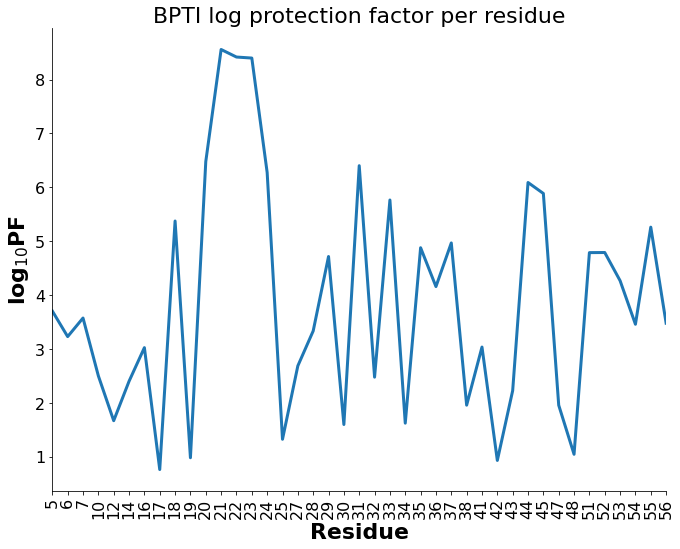

In [46]:
fig, ax = plt.subplots(figsize=(11, 8.5))
xs = np.arange(0, read('segs').iloc[:, 1].shape[0])
ax.plot(xs, expt_data['log10(PF)'])
ax.set_title('BPTI log protection factor per residue')
ax.set_xlabel('Residue')
ax.set_ylabel('log$_{10}$PF')
ax.set_xticks(xs)
ax.set_xlim(xs[0], xs[-1])
ax.set_xticklabels(read('segs').iloc[:, 1], rotation=90)
plt.savefig('BPTI_expt_PFs.pdf', bbox_inches='tight')

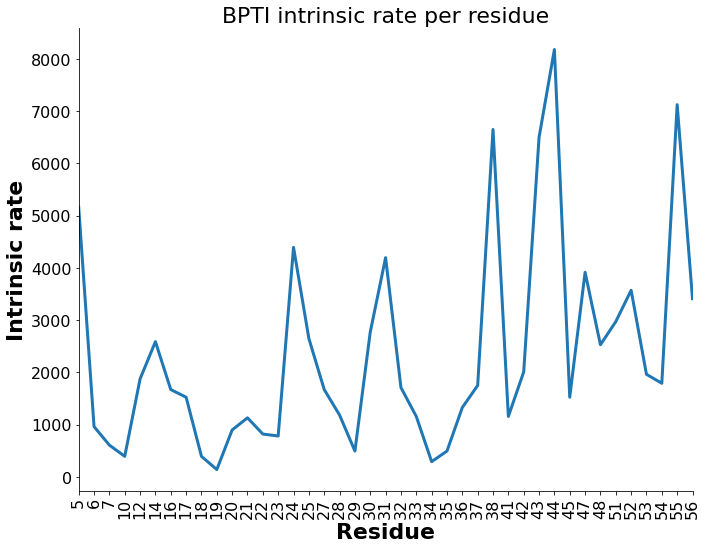

In [47]:
fig, ax = plt.subplots(figsize=(11, 8.5))
xs = np.arange(0, read('segs').iloc[:, 1].shape[0])
ax.plot(xs, expt_data['k_int'])
ax.set_title('BPTI intrinsic rate per residue')
ax.set_xlabel('Residue')
ax.set_ylabel('Intrinsic rate')
ax.set_xticks(xs)
ax.set_xlim(xs[0], xs[-1])
ax.set_xticklabels(read('segs').iloc[:, 1], rotation=90);
plt.savefig('BPTI_k_int.pdf', bbox_inches='tight')

The second function plots HDX deuterated fractions for each time point.

In [44]:
def plot_dfracs(*args):
    """Plot HDX deuterated fractions for each time point.
    
    Args:
        *args: 
            'expt' - experimental HDX deuterated fractions
            'pred' - predicted HDX deuterated fractions
            'reweighted' - reweighted HDX deuterated fractions
    """
    fig, axs = plt.subplots(len(times), 1, figsize=(12, 24))
    for i, (ax, t) in enumerate(zip(axs, times)):
        for arg in args:
            if arg in ['expt', 'pred', 'reweighted']:
                xs = np.arange(0, read(arg).iloc[:, 1].shape[0])
                ax.plot(xs, read(arg).iloc[:, i], label=arg)
                ax.set_title(f'Time = {t} min')
                ax.legend(loc='upper right')
                ax.set_xticks(xs)
                ax.set_xlim(xs[0], xs[-1])
                ax.set_xticklabels(read('segs').iloc[:, 1], rotation=90)
                ax.set_ylim(0, 1)
            else:
                print("Incorrect argument given. Please choose one or more of the following: 'expt' 'pred' 'reweighted'")
    fig.text(0.5, 0.095, 'Residue', ha='center', fontsize=22)
    fig.text(0.05, 0.5, 'HDX deuterated fractions', va='center', rotation='vertical', fontsize=22)

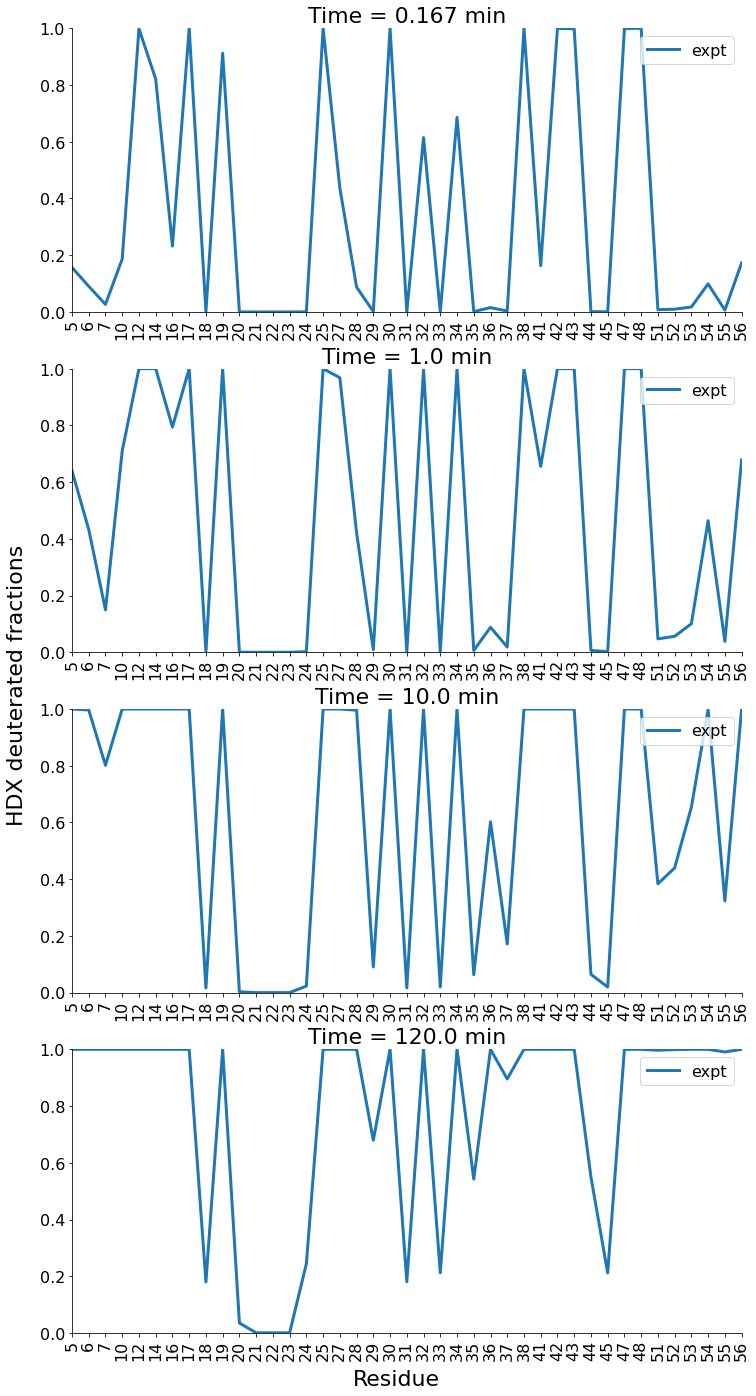

In [45]:
plot_dfracs('expt')

We have organized directories and experimental HDX data converted to deuterated fractions. We can now predict HDX deuterated fractions from the BPTI MD trajectory in the next notebook *02_calc_hdx.ipynb*.